In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import sklearn.metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from tqdm import tqdm
import seaborn as sns

In [30]:
%matplotlib inline
plt.style.use("seaborn-darkgrid")
random_state = 17
np.random.seed(random_state)
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_X = pd.read_csv("train_X.csv", index_col=[0])
train_Y = pd.read_csv("train_Y.csv", index_col=[0])

In [4]:
test_X = pd.read_csv("test_X.csv", index_col=[0])
test_Y = pd.read_csv("test_Y.csv", index_col=[0])

In [5]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=random_state)

In [6]:
param_grid = [
              {},
              {},
              {'learning_rate': [0.1, 0.3], 'max_depth':[10, 30], 'n_estimators':[50, 100, 150]},
              {'n_estimators':[100, 200, 300]},
             ]
estimators = [
              LinearRegression(),
              DecisionTreeRegressor(random_state=random_state),
              XGBRegressor(gpu_id=0, objective='reg:squarederror'),
              RandomForestRegressor(random_state=random_state),
             ]
for i in tqdm(range(len(estimators))):
    print( "*" * 100)
    print("Evaluating Model", estimators[i])
    grid_clf = GridSearchCV(estimators[i], param_grid=param_grid[i], cv=5, verbose=10, n_jobs=12)
    grid_clf.fit(train_X.head(50_000), train_Y.head(50_000))
    print("*" * 100)
    print("Best Score:", grid_clf.best_score_)
    print("Best Params:", grid_clf.best_params_)
    print("\n\n", "*" * 100)
    

  0%|          | 0/4 [00:00<?, ?it/s]

****************************************************************************************************
Evaluating Model LinearRegression()
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 25%|██▌       | 1/4 [00:00<00:02,  1.27it/s]

****************************************************************************************************
Best Score: 0.6299032581885775
Best Params: {}


 ****************************************************************************************************
****************************************************************************************************
Evaluating Model DecisionTreeRegressor(random_state=17)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


 50%|█████     | 2/4 [00:02<00:02,  1.20s/it]

****************************************************************************************************
Best Score: 0.7286160056037798
Best Params: {}


 ****************************************************************************************************
****************************************************************************************************
Evaluating Model XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=0,
             importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)
Fitting 5 

/home/sanjay/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
 75%|███████▌  | 3/4 [07:49<03:34, 214.15s/it]

****************************************************************************************************
Best Score: 0.898796071405315
Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}


 ****************************************************************************************************
****************************************************************************************************
Evaluating Model RandomForestRegressor(random_state=17)
Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/sanjay/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
100%|██████████| 4/4 [11:13<00:00, 168.41s/it]

****************************************************************************************************
Best Score: 0.8689024890248838
Best Params: {'n_estimators': 300}


 ****************************************************************************************************


In [7]:
model = XGBRegressor(learning_rate= 0.1, max_depth= 10, n_estimators= 150, gpu_id=0, objective='reg:squarederror')
model.fit(train_X, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [8]:
prediction = model.predict(test_X)
sklearn.metrics.r2_score(test_Y, prediction)

0.9302023815520439

In [53]:
pred_df = pd.DataFrame()
pred_df["actual"] = test_Y.price
pred_df["predicted"] = prediction
x = [x for x in range(1, len(test_Y)+1)]
pred_df["index"] = x
pred_df.head(10)

,actual,predicted,index
69438,36999,34242.363281,1
319531,23995,22151.187500,2
448760,3200,3774.216797,3
389838,14990,14060.415039,4
73314,4900,7323.877441,5
185037,9995,10147.714844,6
294199,33590,32689.814453,7
237560,15600,22032.945312,8
27561,13977,12590.995117,9
25131,45000,44637.277344,10


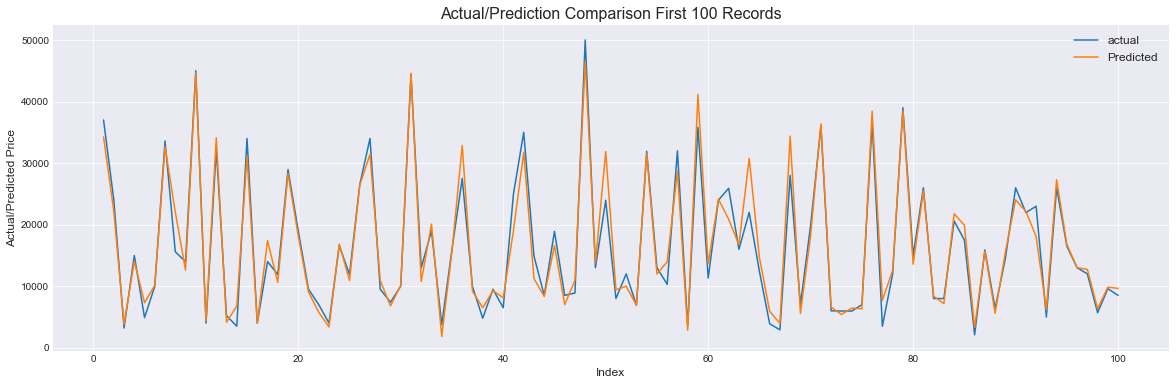

In [77]:
plt.figure(figsize=(20,6))
sns.lineplot(data=pred_df.head(100), x="index", y="actual")
sns.lineplot(data=pred_df.head(100), x="index", y="predicted")
plt.title("Actual/Prediction Comparison First 100 Records", fontsize=16)
plt.legend(["actual", "Predicted"], fontsize=12)
plt.ylabel("Actual/Predicted Price", fontsize=12)
plt.xlabel("Index", fontsize=12)
plt.show()

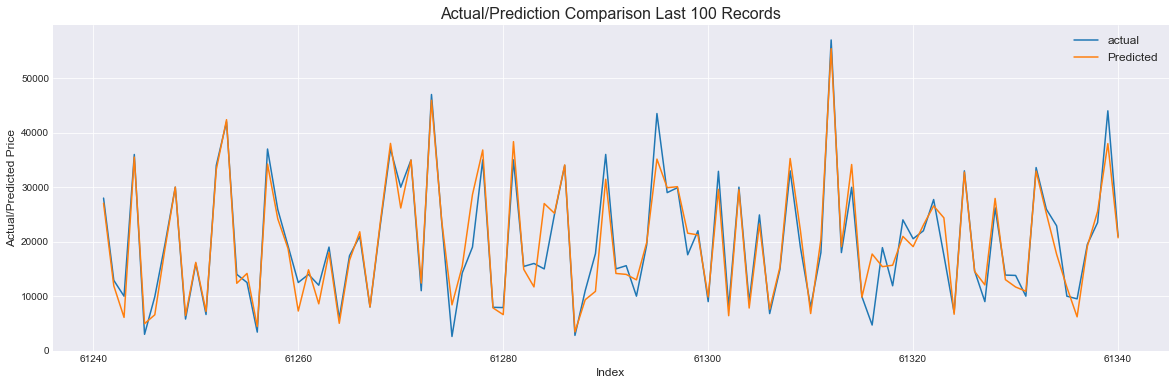

In [75]:
plt.figure(figsize=(20,6))
sns.lineplot(data=pred_df.tail(100), x="index", y="actual")
sns.lineplot(data=pred_df.tail(100), x="index", y="predicted")
plt.title("Actual/Prediction Comparison Last 100 Records", fontsize=16)
plt.legend(["actual", "Predicted"], fontsize=12)
plt.ylabel("Actual/Predicted Price", fontsize=12)
plt.xlabel("Index", fontsize=12)
plt.show()